
# Galaxy cluster spectral analysis 


Objective:
1. Sky tile search, download and merge
2. Extract spectra, ARFs, RMFs using *srctool*
3. Analyze cluster spectra using *pyxspec*

In this notebook, we will cover the first two steps.

### Outline
- Sky tile query
- Data download
- Merge tiles
- Event reprojection
- Spectrum/ARF/RMF extraction
- Spectral binning
- Understanding the generated spectrum/ARF/RMF

In [1]:
# loading modules for this notebook
from IPython.display import Image
import os
import subprocess
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord

os.environ['HEADASNOQUERY']='1'  # to execute heasoft commands without full parameters

In [2]:
# create a directory for analysis
os.makedirs("analysis", exist_ok=True)

## Example: Hydra I cluster (Abell 1060)

- redshift: 0.0129

In [3]:
# Assuming H0 = 70 km/s/Mpc, O_m = 0.3, O_Lambda = 0.7 cosmology
cosmo = FlatLambdaCDM(70, 0.3)
z = 0.0129
kpc_per_arcmin = cosmo.kpc_proper_per_arcmin(z)
Mpc_per_deg = kpc_per_arcmin.to(u.Mpc/u.degree)
display(f"angular scale: {kpc_per_arcmin:.3f} or {Mpc_per_deg:.3f}")


ra_obj = 159.15
dec_obj = -27.518
coord_obj = SkyCoord([ra_obj], [dec_obj], unit="deg")

'angular scale: 15.820 kpc / arcmin or 0.949 Mpc / deg'

## Step 1: search for tiles around the cluster and download the data

Galaxy clusters are extended objects and nearby clusters have angular sizes of dozens of arcminutes. Therefore, a nearby cluster and its local background region might cross multiple tiles. Events of different tiles can be merged using eSASS. We will take Hydra I Cluster (z=0.0129) as an example here.


website: https://erosita.mpe.mpg.de/dr1/erodat/skyview/skytile_search/

- Type "hydra I cluster" in the object box and click **Resolve**
- Set **Radius**: 2.0 deg
- Click **Submit query**

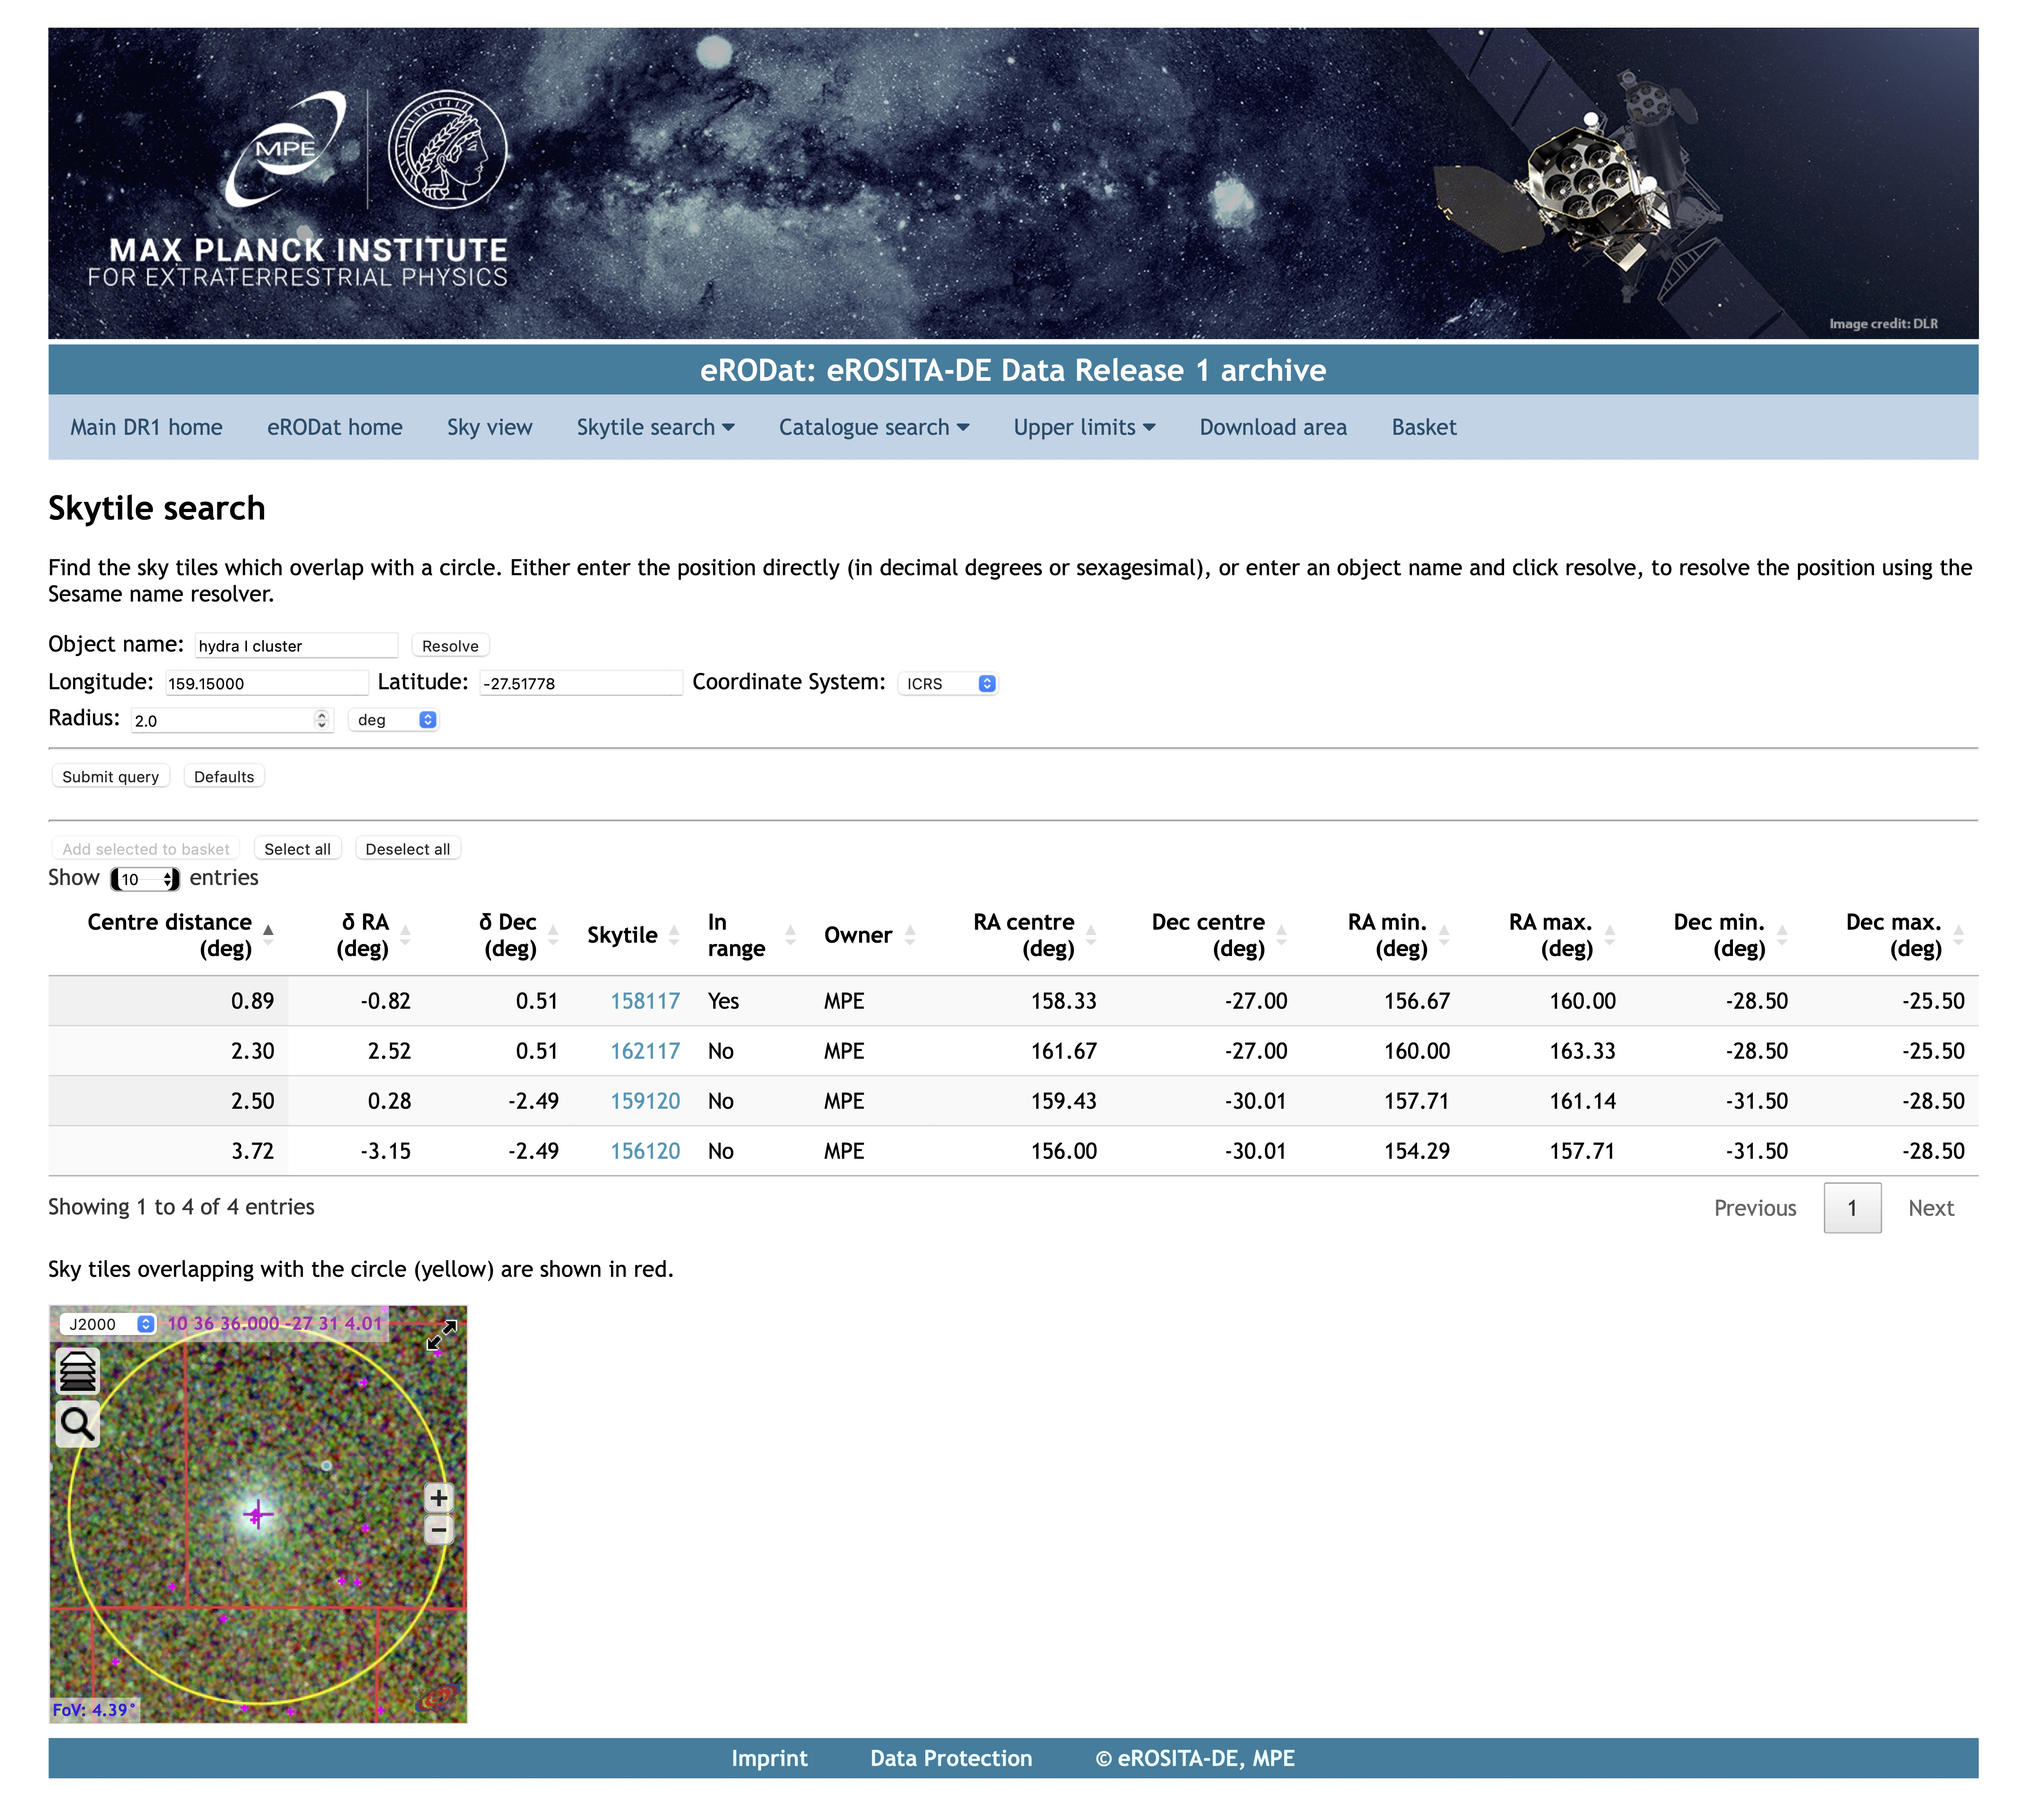

In [4]:
Image("static/Skytile search | eRODat.jpg")

### Download data

To download the data products of the four tiles, click bottoms
1. **Select all**
2. **Add selected to basket**

Then go to the page **Basket**

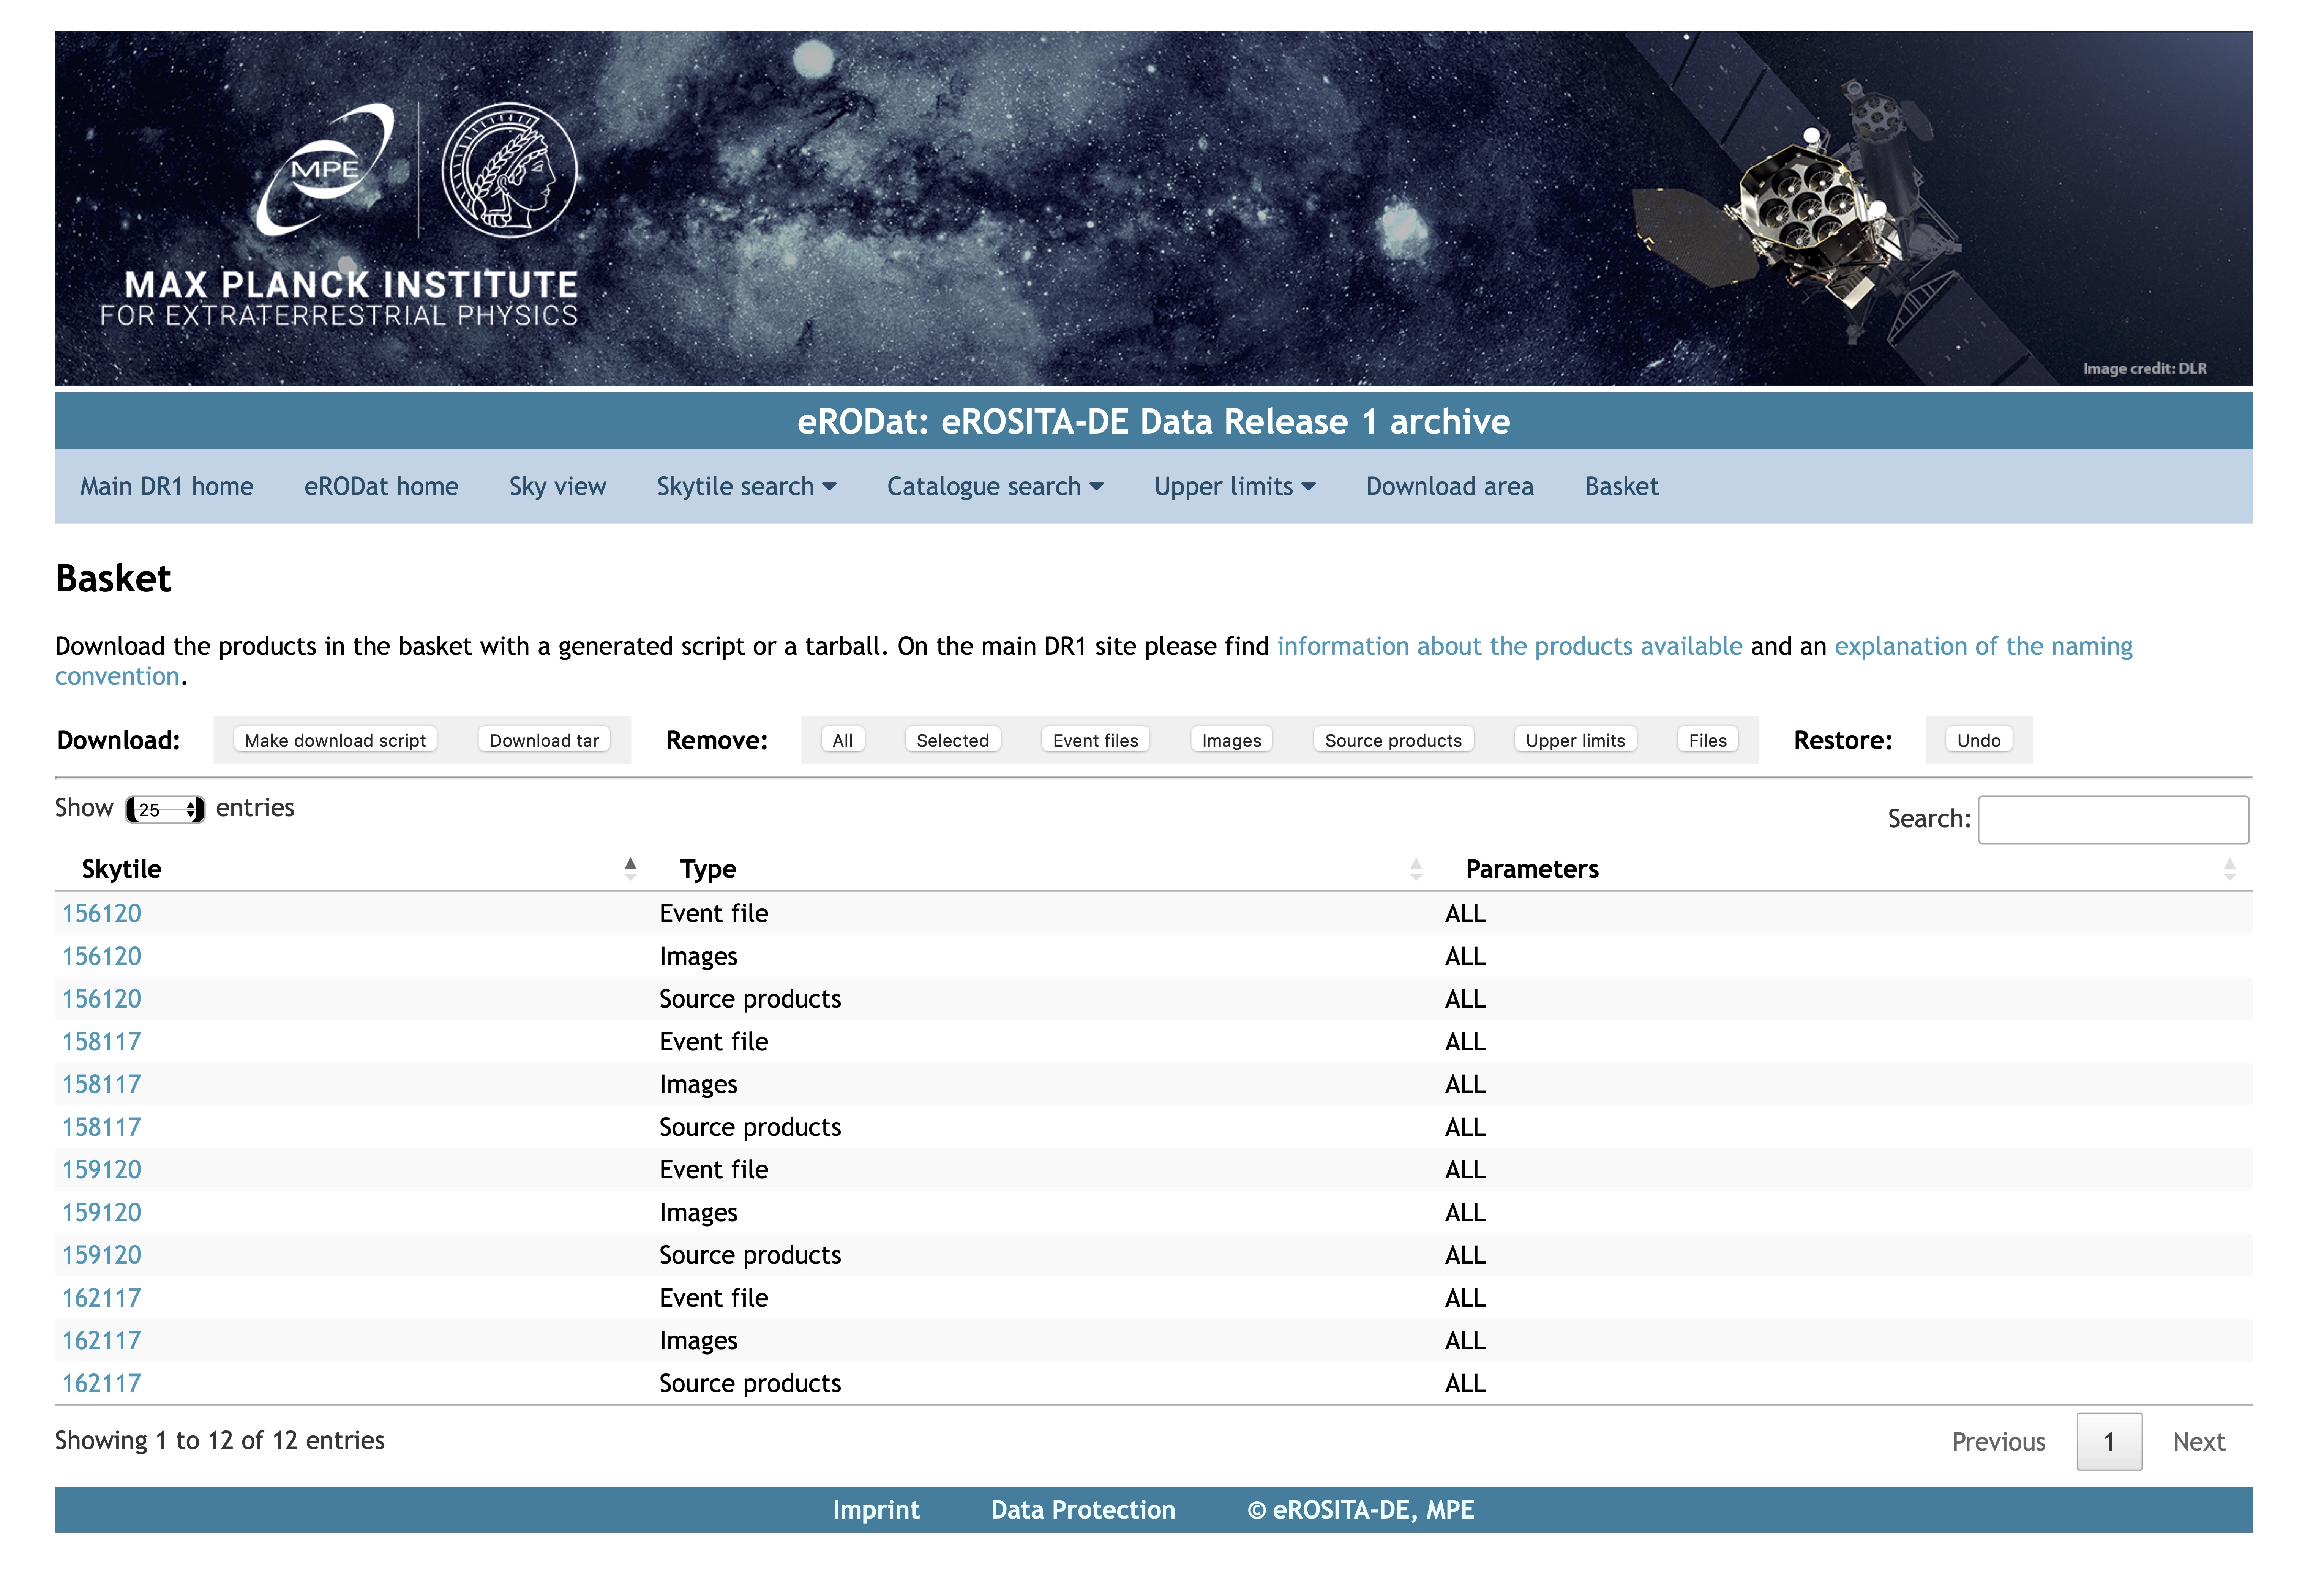

In [5]:
Image("static/Basket | eRODat.jpg")

Here we will only downdoad and Event files.

- Click **Images** and **Source products** to remove them from the basket.
- Click **Download tar** to download the files.
- Make a new directory *data* and cp/mv downloaded files there.

The directory tree structure will be like

In [6]:
! tree data

data
├── 117
│   ├── 158
│   │   └── EXP_010
│   │       └── em01_158117_020_EventList_c010.fits.gz
│   └── 162
│       └── EXP_010
│           └── em01_162117_020_EventList_c010.fits.gz
└── 120
    ├── 156
    │   └── EXP_010
    │       └── em01_156120_020_EventList_c010.fits.gz
    └── 159
        └── EXP_010
            └── em01_159120_020_EventList_c010.fits.gz

11 directories, 4 files


### Merge tiles

Now we will merge the four tile event lists using eSASS command **evtool**.

First, let's generate a text file with paths of the four event list files.

In [7]:
!ls $PWD/data/*/*/*/*EventList*.fits.gz > analysis/event_list.txt

In [8]:
!cat analysis/event_list.txt

/Users/xyzhang/workspace/ahead2020-tutorial/spectral_fitting/data/117/158/EXP_010/em01_158117_020_EventList_c010.fits.gz
/Users/xyzhang/workspace/ahead2020-tutorial/spectral_fitting/data/117/162/EXP_010/em01_162117_020_EventList_c010.fits.gz
/Users/xyzhang/workspace/ahead2020-tutorial/spectral_fitting/data/120/156/EXP_010/em01_156120_020_EventList_c010.fits.gz
/Users/xyzhang/workspace/ahead2020-tutorial/spectral_fitting/data/120/159/EXP_010/em01_159120_020_EventList_c010.fits.gz


Execute **evtool** to merge events

In [9]:
subprocess.run(["evtool", 
                "eventfiles=@analysis/event_list.txt",
                "outfile=analysis/merged_EventList.fits",
                "events=yes"])

########
# NOTE #
########
# The subprocess.run function above is equivalent to
# "evtool eventfiles=@analysis/event_list.txt outfile=analysis/merged_EventList.fits events=yes" 
# in a terminal.

 evtool: 2.29.2.3 eSASS4DR1 Nov 04 14:33:19 2024
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 1
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 2
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 3
 evtool/evtool_main: **WARNING1** GTI filtering not yet done on file 4
 evtool/evtool_main: memset==.false., so memory setting for large files is used.
 evtool/evtool_main: Merging infiles.
 evtool/evtool_main: Merging headers.
 evtool/evtool_main: Update filter settings.
 evtool/evtool_main: Merging extensions.
 evtool/merge_extensions: Merging 4 files.
 evtool/merge_extensions: Infiles will be read 1 extension at a time.
 evtool/del_dup_char_tBinTable: **WARNING1** Number of duplicate rows removed from EVENTS: 162259
 evtool/del_dup_seq_tBinTable: **WARNING1** Number of duplicate rows removed from CORRATT1: 7596
 evtool/del_dup_seq_tBinTable: **WARNING1** Number of duplicate rows removed from CORRATT2: 7590
 evtool/del_dup_seq

CompletedProcess(args=['evtool', 'eventfiles=@analysis/event_list.txt', 'outfile=analysis/merged_EventList.fits', 'events=yes'], returncode=0)

Reproject the merged events using **radec2xy**. The projection center is (RA=159.150, Dec=-27.518)


In [10]:
subprocess.run(["radec2xy", 
                "file=analysis/merged_EventList.fits",
                "ra0=159.15",
                "dec0=-27.518"])

 radec2xy: 1.8.1 eSASS4DR1 Nov 04 14:33:17 2024
 radec2xy/radec2xy:       340713  table rows processed
 radec2xy: DONE


CompletedProcess(args=['radec2xy', 'file=analysis/merged_EventList.fits', 'ra0=159.15', 'dec0=-27.518'], returncode=0)

Let's generate an 4&deg;$\times$4&deg; image around the cluster to check every step above have been done correctly.

In [11]:
subprocess.run(["evtool", 
                "eventfiles=analysis/merged_EventList.fits",
                "outfile=HydraCluster_bin320_img.fits",
                "events=no",
                "image=yes",
                "rebin=320",  # pixel size of 16 arcsec
                "size=900",  # corresponds to 4 deg (16 arcsec * 900 = 4 deg)
                "emin=0.2", 
                "emax=2.3",
                "telid=1 2 3 4 6",  # only keep events from TMs without light-leak
                "gti=FLAREGTI"
                ])  

 evtool: 2.29.2.3 eSASS4DR1 Nov 04 14:33:19 2024
 evtool/validate_tEvtool: **WARNING1** If pixel size (parameter --rebin) is not left at 80, reliable source detection is not guaranteed.
 evtool/evtool_main: memset==.false., so memory setting for large files is used.
 evtool/evtool_main: Merging headers.
 evtool/evtool_main: Update filter settings.
 evtool/evtool_main: Merging extensions.
 evtool/merge_extensions: Merging 1 files.
 evtool/merge_extensions: Infiles will be read 1 extension at a time.
 evtool/evtool_main: Applying filters.
 evtool/apply_gti_tExtension: **WARNING1** Zero rows in BADPIX1 - can't apply GTIs.
 evtool/apply_gti_tExtension: **WARNING1** Zero rows in BADPIX3 - can't apply GTIs.
 evtool/apply_filter_tEventFile: Creating image.
 evtool/create_from_events_tImage2D_i4: **WARNING1** 90351 out of 127437 possible events fall outside the image bounds.
 evtool/evtool_main: Create outfile.
 evtool/evtool_main: Writing outfile.
 evtool/write_tEventFile: Write of events was

CompletedProcess(args=['evtool', 'eventfiles=analysis/merged_EventList.fits', 'outfile=HydraCluster_bin320_img.fits', 'events=no', 'image=yes', 'rebin=320', 'size=900', 'emin=0.2', 'emax=2.3', 'telid=1 2 3 4 6', 'gti=FLAREGTI'], returncode=0)

## Step 2: generate spectra, ARFs and RMFs

Here we will use **srctool** to extract data products for spectral fitting.

We aim to extract a source spectrum from an r = 500 kpc region and a background spectrum from an r = 1.5-2 degree annulus

### Extraction region and source masks

There is a truncated catalog `catalog/eRASS1_Main_around_HydraCluster.fits` that privides eRASS1 detections within a 2.5 degree distance from the Hydra I Cluster. We will use this catalog to create extraction regions with masks.

Catalog column details are given at https://erosita.mpe.mpg.de/dr1/AllSkySurveyData_dr1/Catalogues_dr1/MerloniA_DR1/eRASS1_Main.html

<div class="alert alert-block alert-warning">
<b>Warning:</b> The source masks generated with the eRASS1 main catalog are NOT perfect. You could maks out more sources and remove spurious detections by visual inspection.
</div>

In [12]:
cat_around = Table.read("catalog/eRASS1_Main_around_HydraCluster.fits")

# filter spurious split sources
is_spurious = cat_around["FLAG_SP_GC_CONS"].astype(bool)
cat_around = cat_around[~is_spurious]

# create a SkyCoord object for the catalog enteries.
cat_coord = SkyCoord(cat_around["RA"], cat_around["DEC"], unit="deg")

# distance from catalog entries to the cluster center
distance_cat = cat_coord.separation(coord_obj)

In [13]:
# for 500kpc source region

is_in_600kpc = (distance_cat * kpc_per_arcmin) < 600 * u.kpc  # 600 kpc search radius for some margin 
cat_in_600kpc = cat_around[is_in_600kpc]

with open("analysis/src_500kpc.reg", "w") as f:
    f.write(f"circle({ra_obj},{dec_obj},{500/kpc_per_arcmin.to(u.kpc/u.deg).value})\n")
    for obj in cat_in_600kpc:
        f.write(f"-circle({obj['RA']:.3f},{obj['DEC']:.3f},0.025)\n")  # source mask radius: 1.5 arcmin
    

In [14]:
# for 1.5-2 degree background region

is_in_1p4to2p1deg = (distance_cat < 2.1 * u.deg) & (distance_cat > 1.4 * u.deg)  # 1.4 to 2.1 Mpc search annulus for some margin 
cat_in_bkg = cat_around[is_in_1p4to2p1deg]

with open("analysis/bkg.reg", "w") as f:
    f.write(f"annulus({ra_obj},{dec_obj},1.5,2.0)\n")
    for obj in cat_in_bkg:
        f.write(f"-circle({obj['RA']:.3f},{obj['DEC']:.3f},0.025)\n")  # source mask radius: 1.5 arcmin


### Extract spectra using **srctool**

Command description: https://erosita.mpe.mpg.de/dr1/eSASS4DR1/eSASS4DR1_tasks/srctool_doc.html

<div class="alert alert-block alert-info"> 
In our example, both the source and background regions cover large solid angles. We need to extract the spectra of the two regions separately. 
</div>

Tips:
- The `exttype` parameter could have multiple options depending on how sophiscated the analysis is. In this analysis, we will use a TOPHAT option, which is also known as the FLAT instrument map in XMM `arfgen`.
- Becasue the source size is much larger than the PSF, we ignore the PSF correction for this extended source.

In [15]:
# This will take a few to ten miniutes

# source region
subprocess.run(["srctool",
                "clobber=yes",
                "eventfiles=analysis/merged_EventList.fits", 
                f"srccoord=icrs;{ra_obj:.3f},{dec_obj:.3f}",
                "prefix=analysis/output_spectra/src_500kpc",
                f"todo=SPEC ARF RMF",
                "insts=1 2 3 4 6",
                "writeinsts=8",
                "srcreg=analysis/src_500kpc.reg",
                "backreg=None",
                "exttype=TOPHAT",
                "extpars=2000",  # 2000 arcsec, which is larger than the source region
                "psftype=NONE",  # ignore PSF correction
                "tstep=2", "xgrid=4",  # to boost the speed, this analysis does not require 
                                       # high temporal and spatial precision
                ])

 srctool/srctool: Initialising data structures
 srctool: 1.76.6 eSASS4DR1 Nov 04 14:33:18 2024
 srctool/srctool: Interpreting input parameters
 srctool/srctool_param_interpret_src_par: **WARNING1** Any existing output files will be clobbered!
 srctool/srctool: Reading in eventfile(s)
 srctool/srctool: Reading calibration files from the CALDB
 srctool/ero_cifsl: Accessing cal file tm1_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm2_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm3_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm4_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm6_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm1_instpar_190701v15.fits
 srctool/ero_cifsl: Accessing cal file tm2_instpar_190701v15.fits
 srctool/ero_cifsl: Accessing cal file tm3_instpar_190701v15.fits
 srctool/ero_cifsl: Accessing cal file tm4_instpar_190701v15.fits
 srctool/ero_cifsl: Accessing cal file tm6_instpar_190701v15.fits
 

CompletedProcess(args=['srctool', 'clobber=yes', 'eventfiles=analysis/merged_EventList.fits', 'srccoord=icrs;159.150,-27.518', 'prefix=analysis/output_spectra/src_500kpc', 'todo=SPEC ARF RMF', 'insts=1 2 3 4 6', 'writeinsts=8', 'srcreg=analysis/src_500kpc.reg', 'backreg=None', 'exttype=TOPHAT', 'extpars=2000', 'psftype=NONE', 'tstep=2', 'xgrid=4'], returncode=0)

In [16]:
# background spectrum

subprocess.run(["srctool",
                "clobber=yes",
                "eventfiles=analysis/merged_EventList.fits", 
                f"srccoord=icrs;{ra_obj:.3f},{dec_obj:.3f}",
                "prefix=analysis/output_spectra/bkg_1p5-2deg",
                f"todo=SPEC ARF RMF",
                "insts=1 2 3 4 6",
                "writeinsts=8",
                "srcreg=analysis/bkg.reg",
                "backreg=None",
                "exttype=TOPHAT",
                "extpars=8000",  # 8000 arcsec, which is larger than the source region
                "psftype=NONE",  # ignore PSF correction
                "tstep=2", "xgrid=4",  # to boost the speed, this analysis does not require 
                                       # high temporal and spatial precision
                ])

 srctool/srctool: Initialising data structures
 srctool: 1.76.6 eSASS4DR1 Nov 04 14:33:18 2024
 srctool/srctool: Interpreting input parameters
 srctool/srctool_param_interpret_src_par: **WARNING1** Any existing output files will be clobbered!
 srctool/srctool: Reading in eventfile(s)
 srctool/srctool: Reading calibration files from the CALDB
 srctool/ero_cifsl: Accessing cal file tm1_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm2_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm3_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm4_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm6_detmap_100602v02.fits
 srctool/ero_cifsl: Accessing cal file tm1_instpar_190701v15.fits
 srctool/ero_cifsl: Accessing cal file tm2_instpar_190701v15.fits
 srctool/ero_cifsl: Accessing cal file tm3_instpar_190701v15.fits
 srctool/ero_cifsl: Accessing cal file tm4_instpar_190701v15.fits
 srctool/ero_cifsl: Accessing cal file tm6_instpar_190701v15.fits
 

CompletedProcess(args=['srctool', 'clobber=yes', 'eventfiles=analysis/merged_EventList.fits', 'srccoord=icrs;159.150,-27.518', 'prefix=analysis/output_spectra/bkg_1p5-2deg', 'todo=SPEC ARF RMF', 'insts=1 2 3 4 6', 'writeinsts=8', 'srcreg=analysis/bkg.reg', 'backreg=None', 'exttype=TOPHAT', 'extpars=8000', 'psftype=NONE', 'tstep=2', 'xgrid=4'], returncode=0)

### Binning/grouping the spectra

We will use the method of optimal binning ([Kaastra&Bleeker2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...587A.151K/abstract)) to bin the spectra. The HEASoft tool **ftgrouppha** will be used.

<div class="alert alert-block alert-warning">
<b>Warning:</b> Optimal binning with <b>ftgrouppha</b> will change the value of the `RESPFILE` keyword in the header. We could run it in the directory of generated spectra to avoid it.
</div>

In [17]:
pwd = os.getcwd()
os.chdir("analysis/output_spectra/")


# for source spectrum
subprocess.run(["ftgrouppha",
                "infile=src_500kpc820_SourceSpec_00001.fits",
                "outfile=src_500kpc820_SourceSpec_00001.grp",
                "grouptype=opt",
                "respfile=src_500kpc820_RMF_00001.fits"])

subprocess.run(["ftgrouppha",
                "infile=bkg_1p5-2deg820_SourceSpec_00001.fits",
                "outfile=bkg_1p5-2deg820_SourceSpec_00001.grp",
                "grouptype=opt",
                "respfile=bkg_1p5-2deg820_RMF_00001.fits"])



os.chdir(pwd)

### Understanding **srctool** outputs

#### Spectrum

- EXPOSURE
> The EXPOSURE keyword of the spectrum is given by the total time the source is on a detector (providing NOSRCGTI is not used), after deadtime corrections.

- BACKSCAL
> The BACKSCAL keyword written by SRCTOOL is the average area in square degrees of the intersection of the source region with the detector during the source-specific GTI (unless NOSRCGTI is used). This means that BACSKCAL can be significantly less than the geometric area of the extraction region during scans or the survey.

- REGAREA
> The full geometric area of the region is written (in version 1.63+) as the non-standard keyword REGAREA.

#### ARF

The curve in an ARF is *NOT* the instrument effective area curve. It includes vignetting correction, PSF correction, and a scaling to match the EXPOSURE in the spectrum file.

> These files contain the effective area curves for each source, to be used *alongside* the spectrum files for spectral analysis.